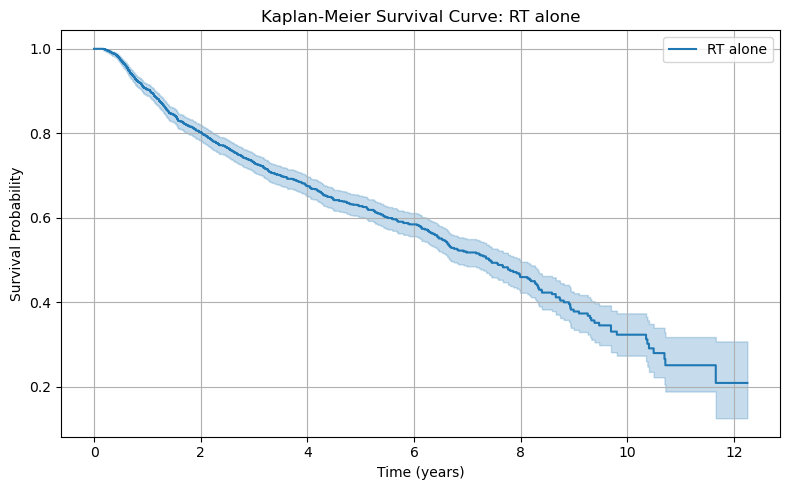

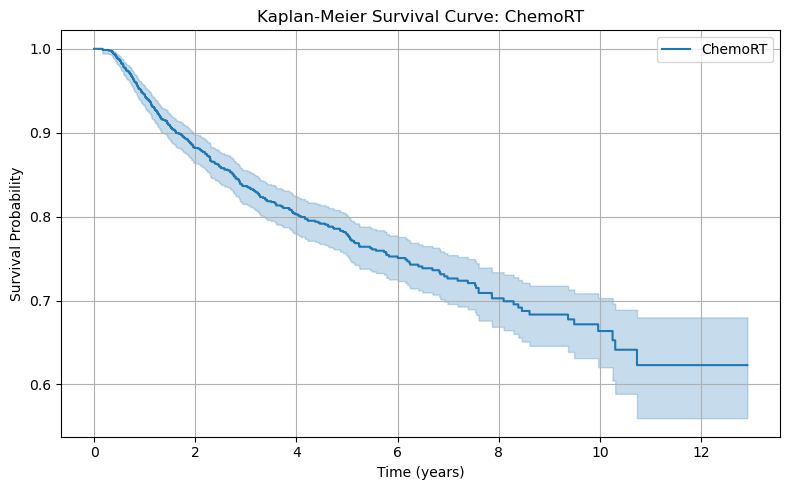

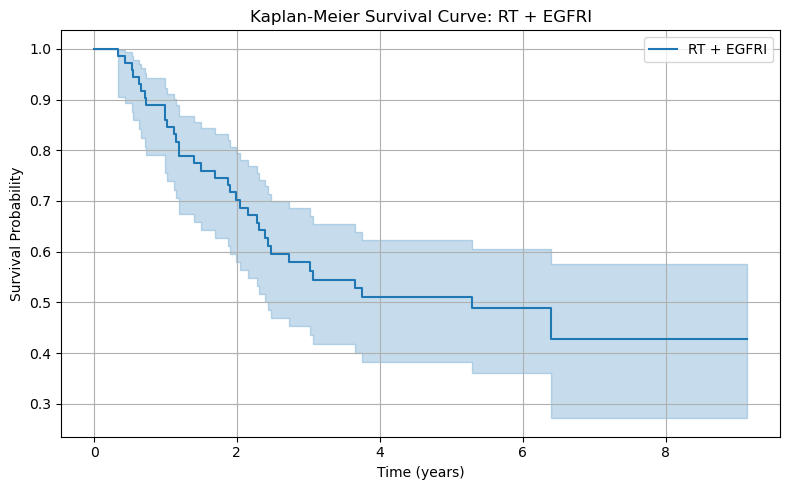

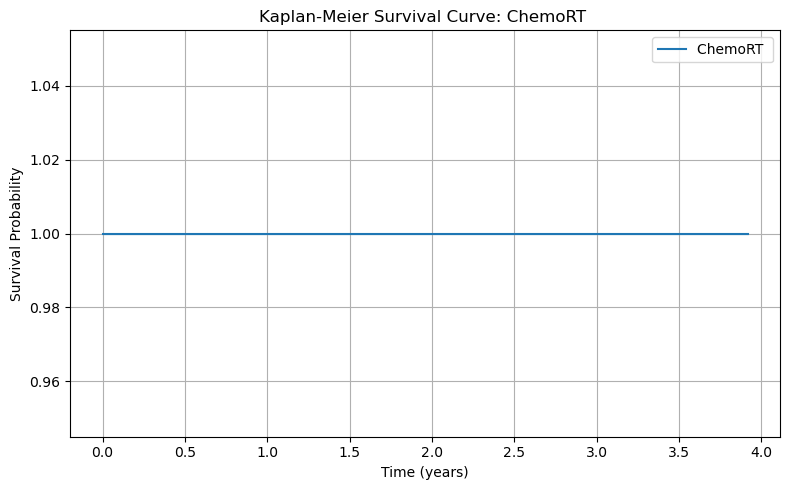

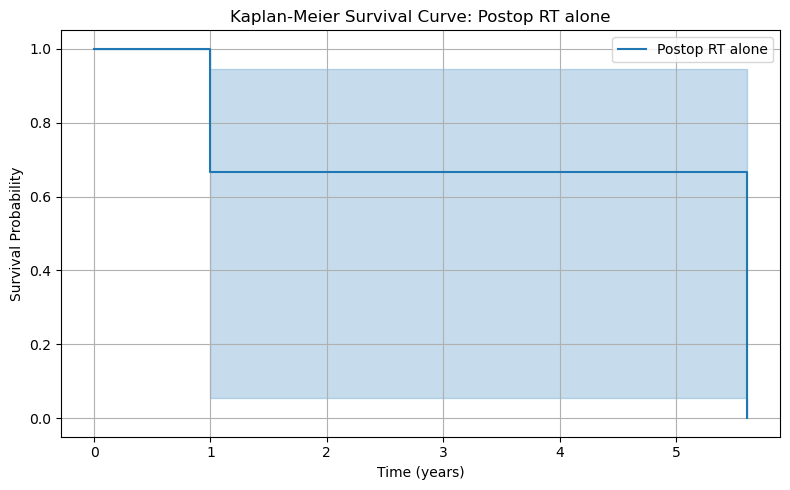


Log-rank test result (Tx Modality groups):
 test_statistic            p  -log2(p)
     130.164423 3.591198e-27 87.847593


/var/folders/lc/0fqy2gd15rq5cbfwv1v18kz40000gp/T/ipykernel_8758/109162069.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cox_df['ECOG PS'] = cox_df['ECOG PS'].astype(str).str.extract(r'(\d+)')
/var/folders/lc/0fqy2gd15rq5cbfwv1v18kz40000gp/T/ipykernel_8758/109162069.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cox_df['ECOG PS'] = pd.to_numeric(cox_df['ECOG PS'], errors='coerce')



Cox Proportional Hazards Model Summary:
                 coef     exp(coef)      se(coef)  coef lower 95%  \
covariate                                                           
Age          0.042524  1.043441e+00      0.002979        0.036686   
ECOG PS      0.512353  1.669215e+00      0.038776        0.436353   
Stage_I     -0.391461  6.760687e-01      0.275327       -0.931092   
Stage_IB   -18.631371  8.100245e-09  58124.829537  -113941.203871   
Stage_II    -0.175624  8.389330e-01      0.267931       -0.700760   
Stage_IIA  -12.231860  4.872712e-06    699.955172    -1384.118789   
Stage_IIB    1.667711  5.300024e+00      1.032202       -0.355368   
Stage_III    0.030372  1.030837e+00      0.261455       -0.482070   
Stage_IIIA   1.830194  6.235093e+00      0.753879        0.352618   
Stage_IIIC   1.757702  5.799094e+00      0.752535        0.282759   
Stage_IV     0.751134  2.119402e+00      0.454681       -0.140025   
Stage_IVA    0.208974  1.232413e+00      0.255175       -0.291

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from lifelines.statistics import multivariate_logrank_test
from lifelines import CoxPHFitter
from sksurv.ensemble import RandomSurvivalForest
from sksurv.util import Surv
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from lifelines.utils import concordance_index


df = pd.read_csv("RADCURE_TCIA_Clinical_r2_offset-Table 1.csv")  


df['event'] = df['Status'].apply(lambda x: 1 if str(x).lower() == 'dead' else 0)
df['duration'] = df['Length FU']  


df_km = df[['duration', 'event', 'Tx Modality']].dropna()


treatment_groups = df_km['Tx Modality'].unique().tolist()


kmf = KaplanMeierFitter()

for group in treatment_groups:
    plt.figure(figsize=(8, 5))

    # Filter group
    group_data = df_km[df_km['Tx Modality'] == group]

    # Fitting model and plot
    kmf.fit(
        durations=group_data['duration'].values,
        event_observed=group_data['event'].values,
        label=str(group)
    )
    ax = kmf.plot_survival_function()
    ax.set_title(f"Kaplan-Meier Survival Curve: {group}")
    ax.set_xlabel("Time (years)")
    ax.set_ylabel("Survival Probability")
    ax.grid(True)
    plt.tight_layout()
    plt.show()


results = multivariate_logrank_test(
    df_km['duration'].values,
    df_km['Tx Modality'].values,
    df_km['event'].values
)

print("\nLog-rank test result (Tx Modality groups):")
summary_text = results.summary.to_string(index=False)
print(summary_text)




# Selecting needed columns
cox_df = df[['duration', 'event', 'Age', 'ECOG PS', 'Stage']]

# Clean ECOG PS: extract number and convert to float
cox_df['ECOG PS'] = cox_df['ECOG PS'].astype(str).str.extract(r'(\d+)')
cox_df['ECOG PS'] = pd.to_numeric(cox_df['ECOG PS'], errors='coerce') 

# Convert Stage to dummy variables
cox_df = pd.get_dummies(cox_df, columns=['Stage'], drop_first=True)

# Drop any rows with missing values after cleaning
cox_df = cox_df.dropna()

# Fit Cox model
cph = CoxPHFitter()
cph.fit(cox_df, duration_col='duration', event_col='event')

print("\nCox Proportional Hazards Model Summary:")
#print(cph.summary.to_string(index=False))  
print(cph.summary)



# Prepare survival data
y = Surv.from_arrays(event=cox_df['event'].astype(bool), time=cox_df['duration'])
X = cox_df.drop(columns=['duration', 'event'])

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Survival Forest
rsf = RandomSurvivalForest(random_state=42)
rsf.fit(X_train, y_train)

# Calculate C-index on test data
cindex_rsf = rsf.score(X_test, y_test)
print(f"RSF C-index on test set: {cindex_rsf:.4f}")

# Calculate Cox PH model C-index on test data
cox_test_df = X_test.copy()
cox_test_df['duration'] = [t for e, t in y_test]
cox_test_df['event'] = [e for e, t in y_test]

cindex_cox = concordance_index(
    cox_test_df['duration'],
    -cph.predict_partial_hazard(cox_test_df),
    cox_test_df['event']
)
print(f"Cox PH C-index on test set: {cindex_cox:.4f}")

# Define custom scoring function for permutation importance
def cindex_scorer(model, X_val, y_val):
    risk_scores = -model.predict(X_val)
    times = [t for e, t in y_val]
    events = [e for e, t in y_val]
    return concordance_index(times, risk_scores, events)

# Use a sample of test data for speed
X_test_sample = X_test.sample(min(len(X_test), 100), random_state=42)

# Compute permutation importance using the custom scorer
perm_importance = permutation_importance(
    rsf,
    X_test_sample,
    y_test[:len(X_test_sample)],
    scoring=cindex_scorer,
    n_repeats=10,
    random_state=42,
    n_jobs=-1
)

# Print permutation feature importance
print("\nPermutation Feature Importance (mean decrease in C-index):")
sorted_idx = perm_importance.importances_mean.argsort()[::-1]
for idx in sorted_idx:
    print(f"{X.columns[idx]:<20}: {perm_importance.importances_mean[idx]:.4f} ± {perm_importance.importances_std[idx]:.4f}")





